This code models the basis point spread of a Credit Default Swap (per unit notional) using a Vasicek model of the interest rates. Inputs are to be tweaked as necessary, such as the Vasicek parameters or the CDS parameters (hazard rate, recovery rate, etc.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Vasicek interest rate model parameters
"""Note: This has not been derived from current market data, these are placeholder values and should be changed as necessary."""
a = 0.02  # Speed of reversion
b = 0.04  # Long-term mean level
sigma = 0.01  # Volatility
r0 = 0.05  # Initial interest rate
dt = 1/252  # Daily time step for interest rate simulation
T = 5  # Maturity in years for CDS
N = int(T / dt)  # Number of time steps for interest rate simulation
MC_simulations = 500  # Number of Monte Carlo simulations

In [3]:
# Simulate Vasicek interest rate path
def simulate_vasicek(r0, a, b, sigma, T, dt, N):
    rates = np.zeros(N)
    rates[0] = r0
    for t in range(1, N):
        dr = a * (b - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr
    return rates

# Calculate discount factors for a given interest rate path
def discount_factors(rates, dt):
    return np.exp(-np.cumsum(rates) * dt)

In [4]:
# Modified CDS pricing function to incorporate stochastic interest rates
def cds_spread_stochastic_rates(hazard_rate, recovery_rate, notional, maturity, frequency, simulations):
    dt = 1 / frequency
    no_of_periods = int(maturity * frequency)
    spreads = np.zeros(simulations)
    
    for sim in range(simulations):
        # Simulate interest rate path for each Monte Carlo simulation
        rates = simulate_vasicek(r0, a, b, sigma, T, dt, N)
        # Calculate discount factors for the simulated path
        dfs = discount_factors(rates, dt)[:no_of_periods]  # Truncate to match CDS maturity
        survival_probability = np.exp(-hazard_rate * np.arange(1, no_of_periods + 1) / frequency)
        expected_premiums = (1 - survival_probability) * dfs
        expected_protection = (1 - recovery_rate) * np.sum(expected_premiums)
        annual_premium = expected_protection / (np.sum(dfs * survival_probability) * dt)
        spreads[sim] = annual_premium * notional
    
    # Average the spreads from all simulations
    average_spread = np.mean(spreads)
    return average_spread

Average CDS Spread with Stochastic Interest Rates per unit notional: 0.091533 basis points


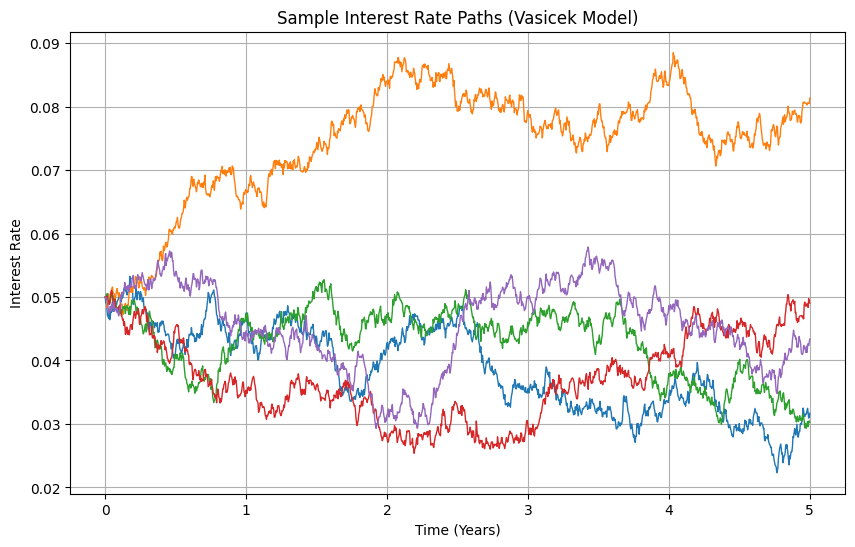

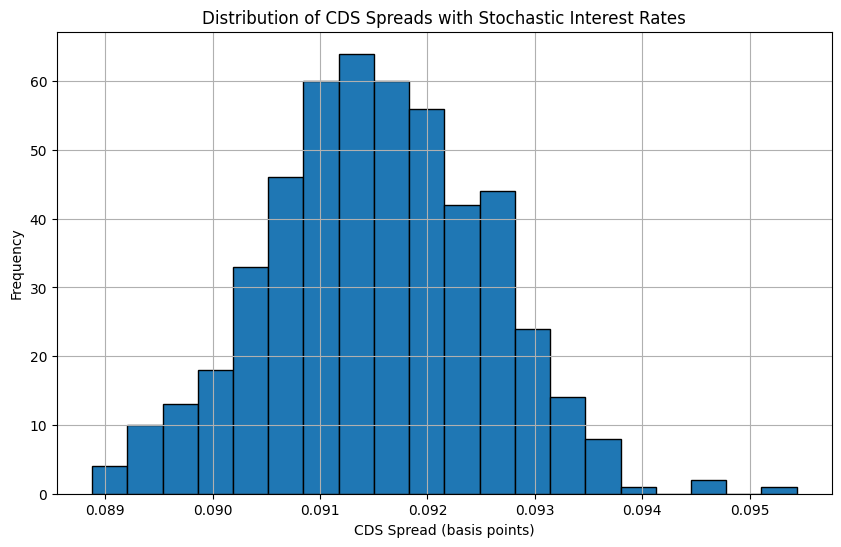

In [29]:
# Parameters
hazard_rate = 0.01  # Probability of default per year
recovery_rate = 0.1  # Recovery rate in event of default
notional = 1  # Using 1 for simplicity; spread is per unit of notional
frequency = 4  # Payment frequency

# Calculate CDS Spread with stochastic interest rates
spread_stochastic = cds_spread_stochastic_rates(hazard_rate, recovery_rate, notional, T, frequency, MC_simulations)
print(f"Average CDS Spread with Stochastic Interest Rates per unit notional: {spread_stochastic:.6f} basis points")

# Plot a subset of interest rate paths
num_paths_to_plot = 5
plt.figure(figsize=(10, 6))
for _ in range(num_paths_to_plot):
    rates = simulate_vasicek(r0, a, b, sigma, T, dt, N)
    plt.plot(np.linspace(0, T, N), rates, lw=1)
plt.title('Sample Interest Rate Paths (Vasicek Model)')
plt.xlabel('Time (Years)')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

# Monte Carlo simulation for CDS spreads
spreads = [cds_spread_stochastic_rates(hazard_rate, recovery_rate, notional, T, frequency, 1) for _ in range(MC_simulations)]

# Plot the distribution of CDS spreads
plt.figure(figsize=(10, 6))
plt.hist(spreads, bins=20, edgecolor='black')
plt.title('Distribution of CDS Spreads with Stochastic Interest Rates')
plt.xlabel('CDS Spread (basis points)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
